In [109]:
library(extrafont)
library(tidyverse)
library(epidemia)
library(arrow)

# 1. parameters

In [110]:
T0 = 40

## observation parameters

In [111]:
alpha = 0.01

$$Y_t = NegBinom( \frac{EY_t}{r_Y + EY_t}, r_Y )$$

$$ EY_t = \alpha\sum_{s=1}^{t-1} I_s \pi_{t-s} $$

## latent parameters

In [112]:
K = 6.5

$$I_t = NegBinom( \frac{EI_t}{r_I + EI_t}, r_I )$$

$$ EI_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1} I_s g_{t-s} $$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(- \beta^\top A_t)}$$

## seed values

$$I_{-T_0} = \mu_0$$

In [113]:
param <- read_feather('data/param_ebcr_2.feather')

In [114]:
names(param) <- c('region', 'mu', 'beta0', 'beta1')

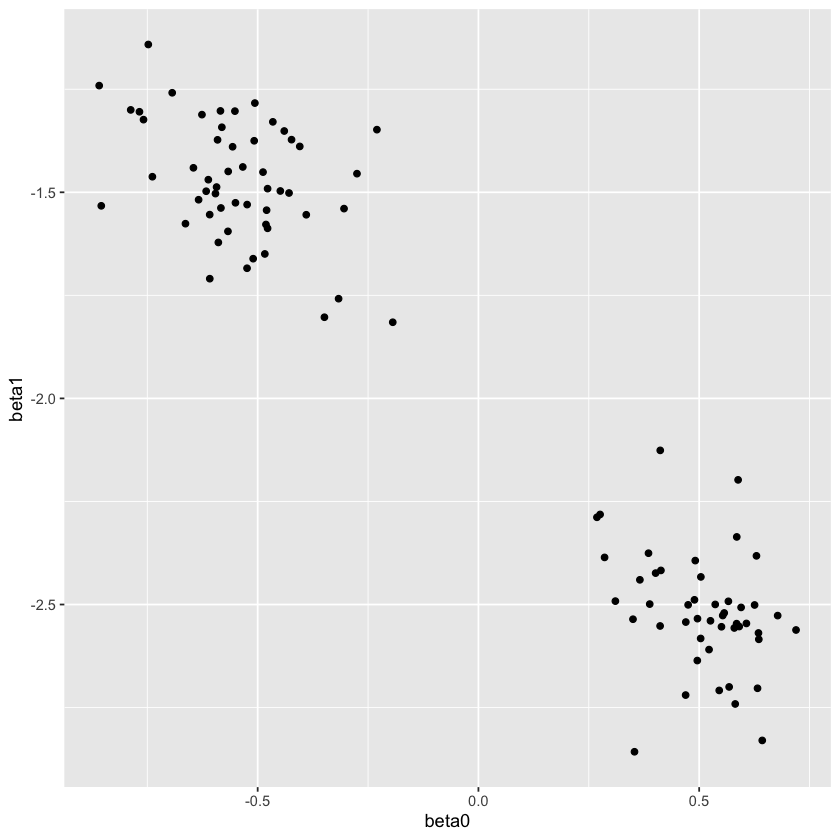

In [115]:
ggplot(param, aes(x=beta0, y=beta1)) + geom_point()

# 2. load simulation data

In [116]:
data <- read_feather('data/simulation_ebcr_2.feather')

In [117]:
data$date = as.Date("2022-01-01") + data$date

In [118]:
data = data %>% group_by(region) %>% group_modify(~ {
    data.frame(date = c(min(.x$date)+(-T0:-1), .x$date),
               death = c(rep(NA,T0), .x$death),
               intervention = c(rep(0,T0), .x$intervention))}
)

In [119]:
head(data)

region,date,death,intervention
<chr>,<date>,<int>,<dbl>
aa,2021-11-22,NA,0
aa,2021-11-23,NA,0
aa,2021-11-24,NA,0
aa,2021-11-25,NA,0
aa,2021-11-26,NA,0
aa,2021-11-27,NA,0


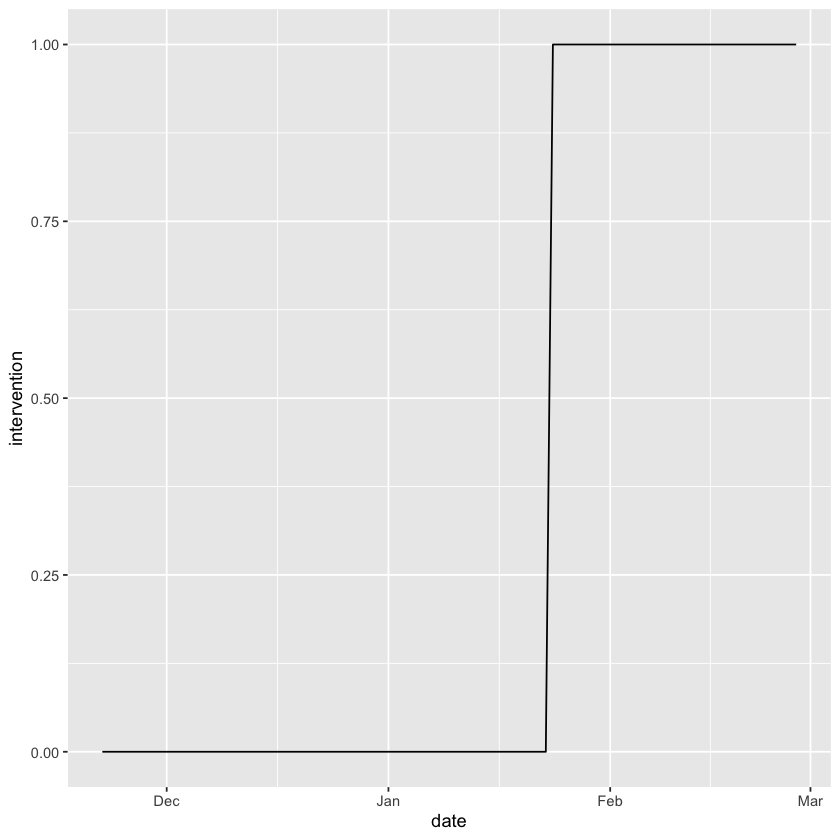

In [120]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=intervention)) + geom_line()

Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


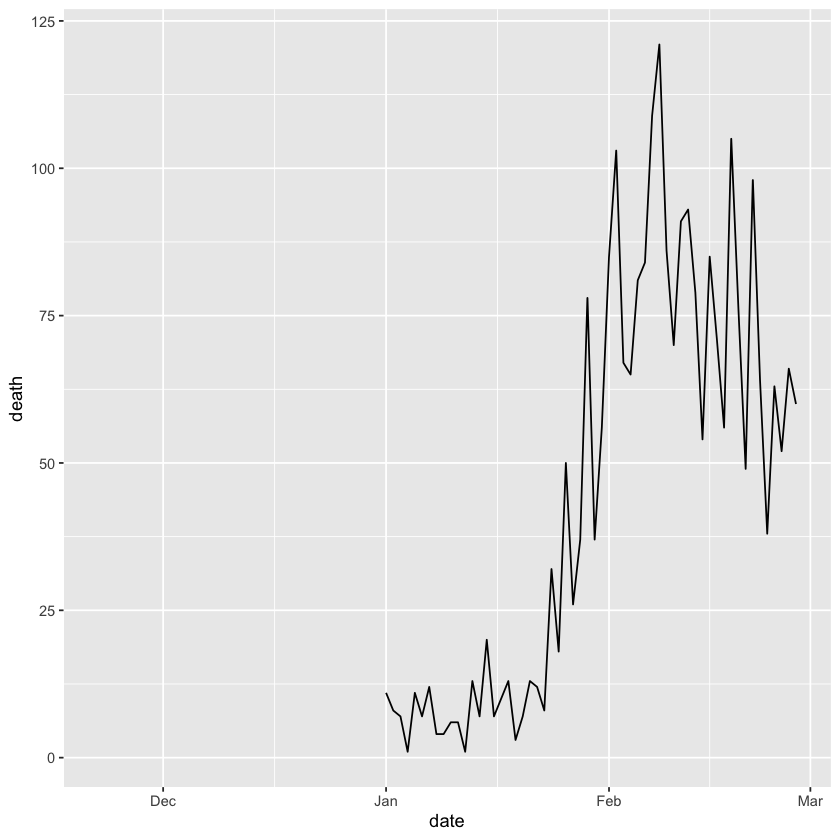

In [121]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(data %>% filter(region == param$region[4]), aes(x=date, y=death)) + geom_line()

# 2. fit

In [122]:
rt <- epirt(formula = R(region, date) ~ 1 + intervention
            + (1 + intervention || region),
            prior = shifted_gamma(shape = 1/6, scale = 1, shift = log(1.05)/6),
            prior_covariance = decov(shape = c(2, 0.5), scale = 0.25),
            link = scaled_logit(K))

In [123]:
inf <- epiinf(gen = EuropeCovid$si, seed_days = T0)

In [124]:
deaths <- epiobs(formula = death ~ 1, i2o = EuropeCovid2$inf2death,
                 prior_intercept = normal(0, 0.01), link = scaled_logit(2*alpha))

Warning message:
“i2o does not sum to one. Please ensure this is intentional.”


In [125]:
args <- list(rt = rt, inf = inf, obs = deaths, data = data, 
             seed=12345, refresh=0)

In [126]:
args$algorithm <- "fullrank"; args$iter <- 5e4; args$tol_rel_obj <- 1e-3

In [127]:
fm <- do.call(epim, args)

Warning message:
“Pareto k diagnostic value is 17.27. Resampling is disabled. Decreasing tol_rel_obj may help if variational algorithm has terminated prematurely. Otherwise consider using sampling instead.”


In [128]:
as.data.frame(fm$stanfit)

R|(Intercept),R|intervention,R|b[(Intercept) region:aa],R|b[(Intercept) region:ab],R|b[(Intercept) region:ac],R|b[(Intercept) region:ad],R|b[(Intercept) region:ae],R|b[(Intercept) region:af],R|b[(Intercept) region:ag],R|b[(Intercept) region:ah],⋯,seeds[dp],seeds[dq],seeds[dr],seeds[ds],seeds[dt],seeds[du],seeds[dv],seeds_aux,death|reciprocal dispersion,log-posterior
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00878023,-1.70577,-0.00928217,-0.0801038,-0.1852900,-0.405880,-0.359863,0.31500100,-0.464168,-0.117533000,⋯,175.424,138.5560,798.745,366.296,606.250,244.436,219.402,233.0800,10.2231,0
-0.33622900,-1.69306,0.20674200,0.0123162,-0.0495071,-0.275094,-0.239649,0.35229800,-0.215083,0.048500800,⋯,237.535,225.4720,866.141,573.588,720.249,324.874,413.132,130.0950,10.2176,0
0.13391900,-2.02150,0.05550300,-0.3125900,-0.2876360,-0.524596,-0.563123,0.11888900,-0.619603,-0.126012000,⋯,196.506,215.9730,801.734,503.928,777.905,189.246,210.343,124.5110,10.1341,0
0.12808300,-2.13965,-0.09037030,-0.1987160,-0.2282210,-0.562207,-0.455484,0.17518600,-0.544863,0.040402200,⋯,155.409,155.2880,925.931,329.873,551.889,172.127,288.297,89.5044,10.1890,0
0.05360340,-2.01657,0.15975600,-0.2109320,-0.1812430,-0.342956,-0.403456,0.15181000,-0.501347,0.060090600,⋯,220.135,148.7760,809.485,342.539,727.372,185.291,245.260,146.7400,10.2531,0
0.22588400,-1.98778,-0.06653000,-0.3541240,-0.3783030,-0.551479,-0.476051,0.09146870,-0.640776,-0.047248500,⋯,174.071,133.9610,679.367,406.937,613.309,185.783,206.561,177.9910,10.1569,0
-0.08848100,-1.65210,0.01888590,-0.2960710,-0.1992430,-0.482621,-0.530443,0.16053500,-0.481226,0.101356000,⋯,189.970,329.3100,886.118,579.806,785.504,232.774,442.400,209.2920,10.1322,0
0.15119100,-2.17845,0.16642000,-0.2931570,-0.3547020,-0.592839,-0.407155,0.36534800,-0.408233,0.019448500,⋯,218.519,116.6070,615.611,464.026,628.354,172.997,223.690,125.7660,10.1270,0
0.11505900,-2.28818,0.44234700,-0.3866990,-0.2492450,-0.492146,-0.418464,0.00574415,-0.438454,0.243338000,⋯,158.903,185.4570,629.284,376.626,530.332,188.071,228.464,113.0110,10.1543,0


In [129]:
write_feather(as.data.frame(fm$stanfit), 
              'result_epidemia_ebcr_2.feather')

## plots

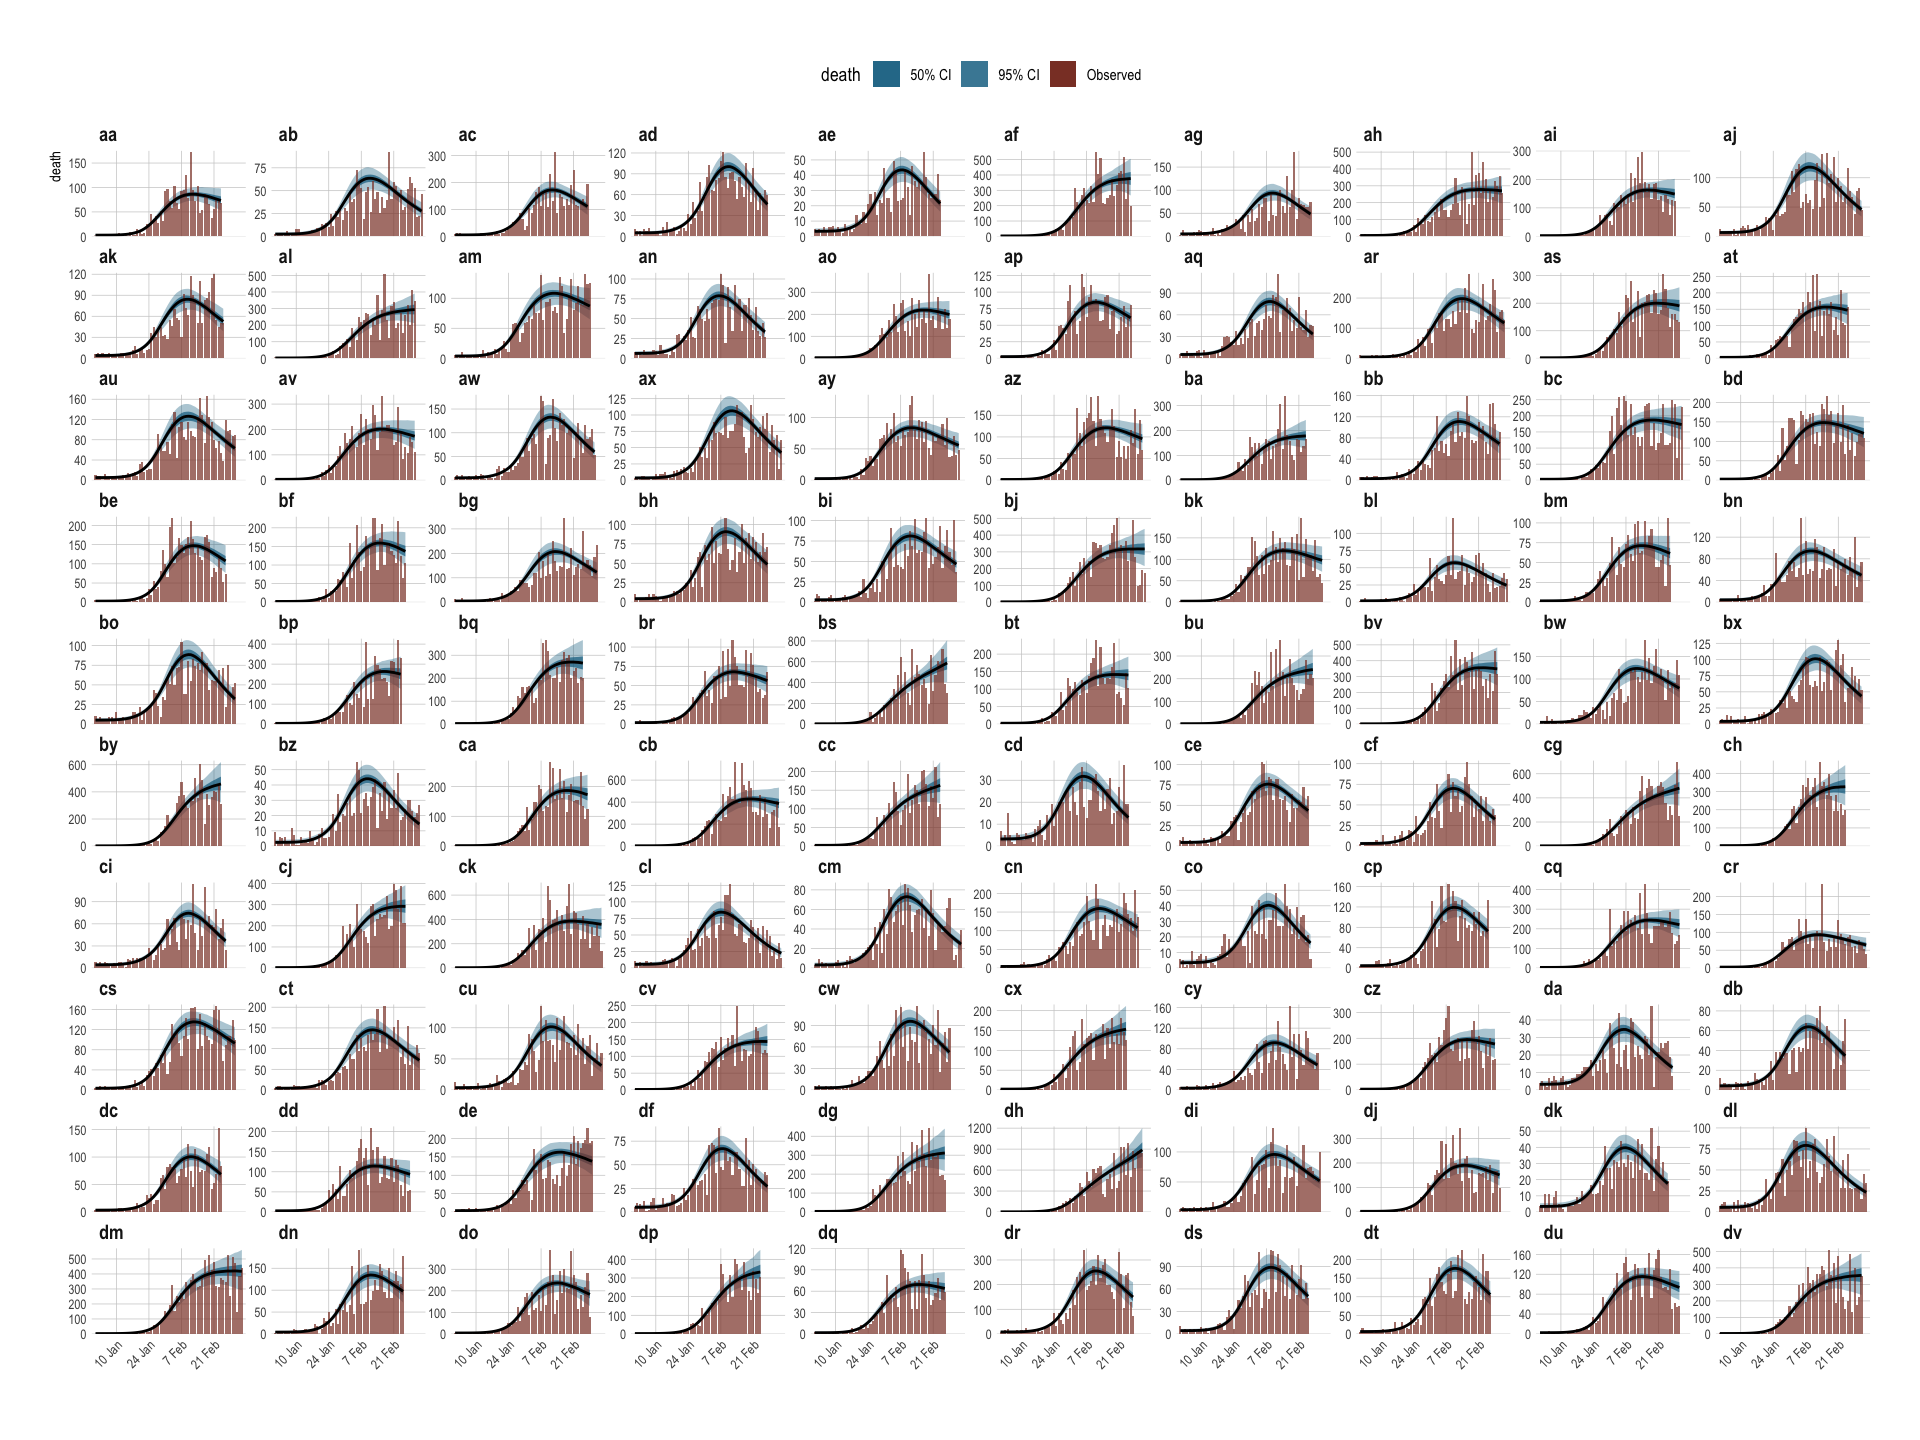

In [130]:
options(repr.plot.width = 16, repr.plot.height = 12)
plot_obs(fm, type="death", levels = c(50, 95), posterior_mean=TRUE)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


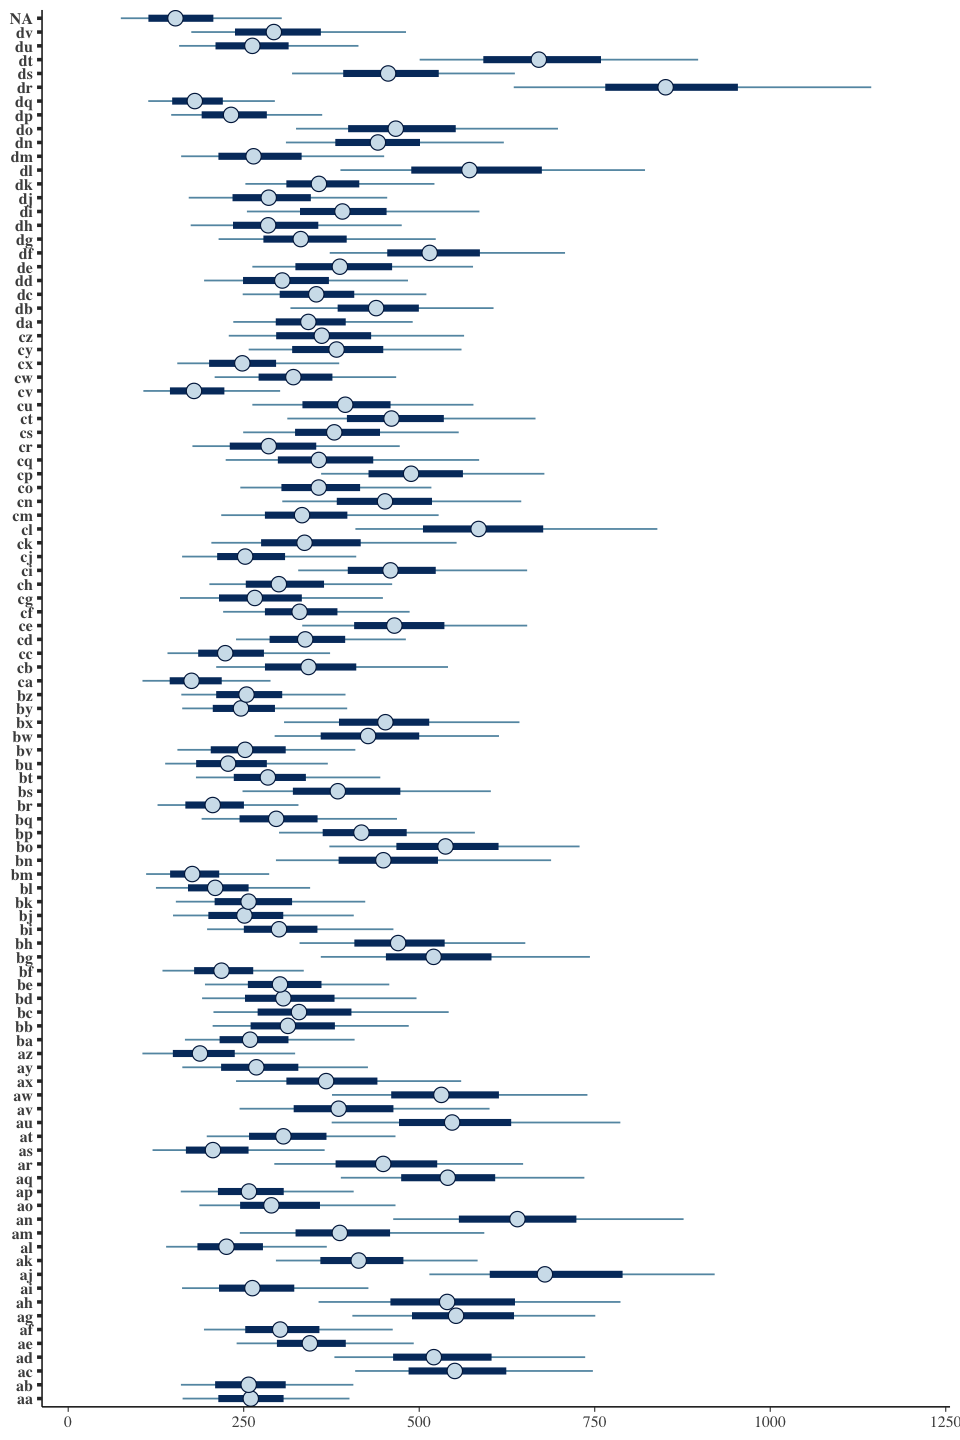

In [131]:
options(repr.plot.width = 8, repr.plot.height = 12)

mat <- as.matrix(fm, "areas", regex_pars = "seeds", par_groups = fm$groups)
bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [132]:
m_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


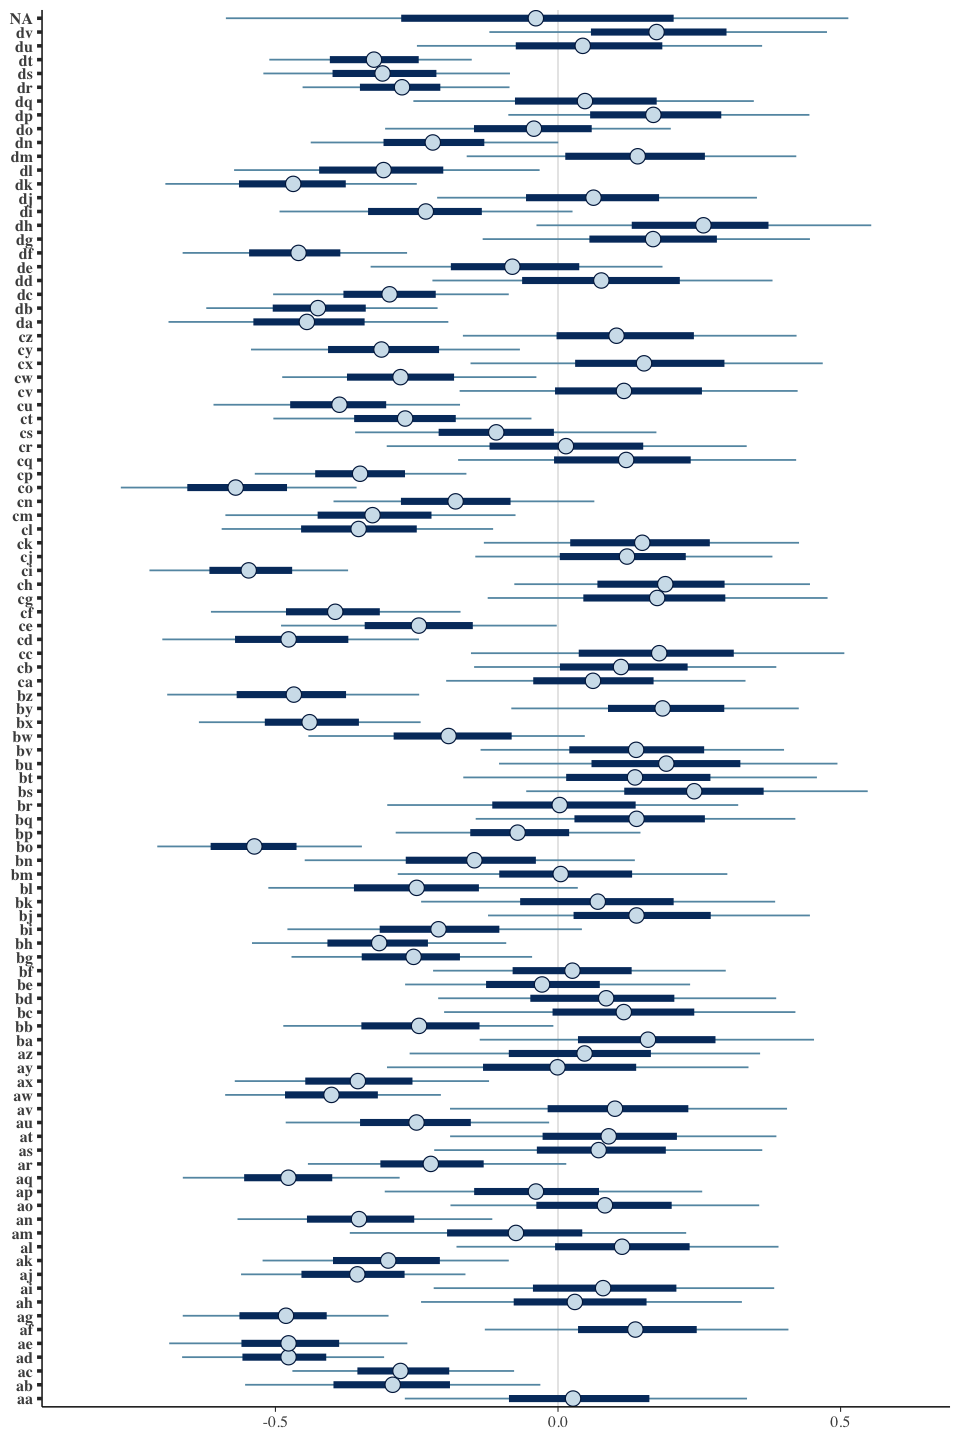

In [133]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|\\(Int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[\\(Int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [134]:
b0_epi = apply(mat, 2, mean)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


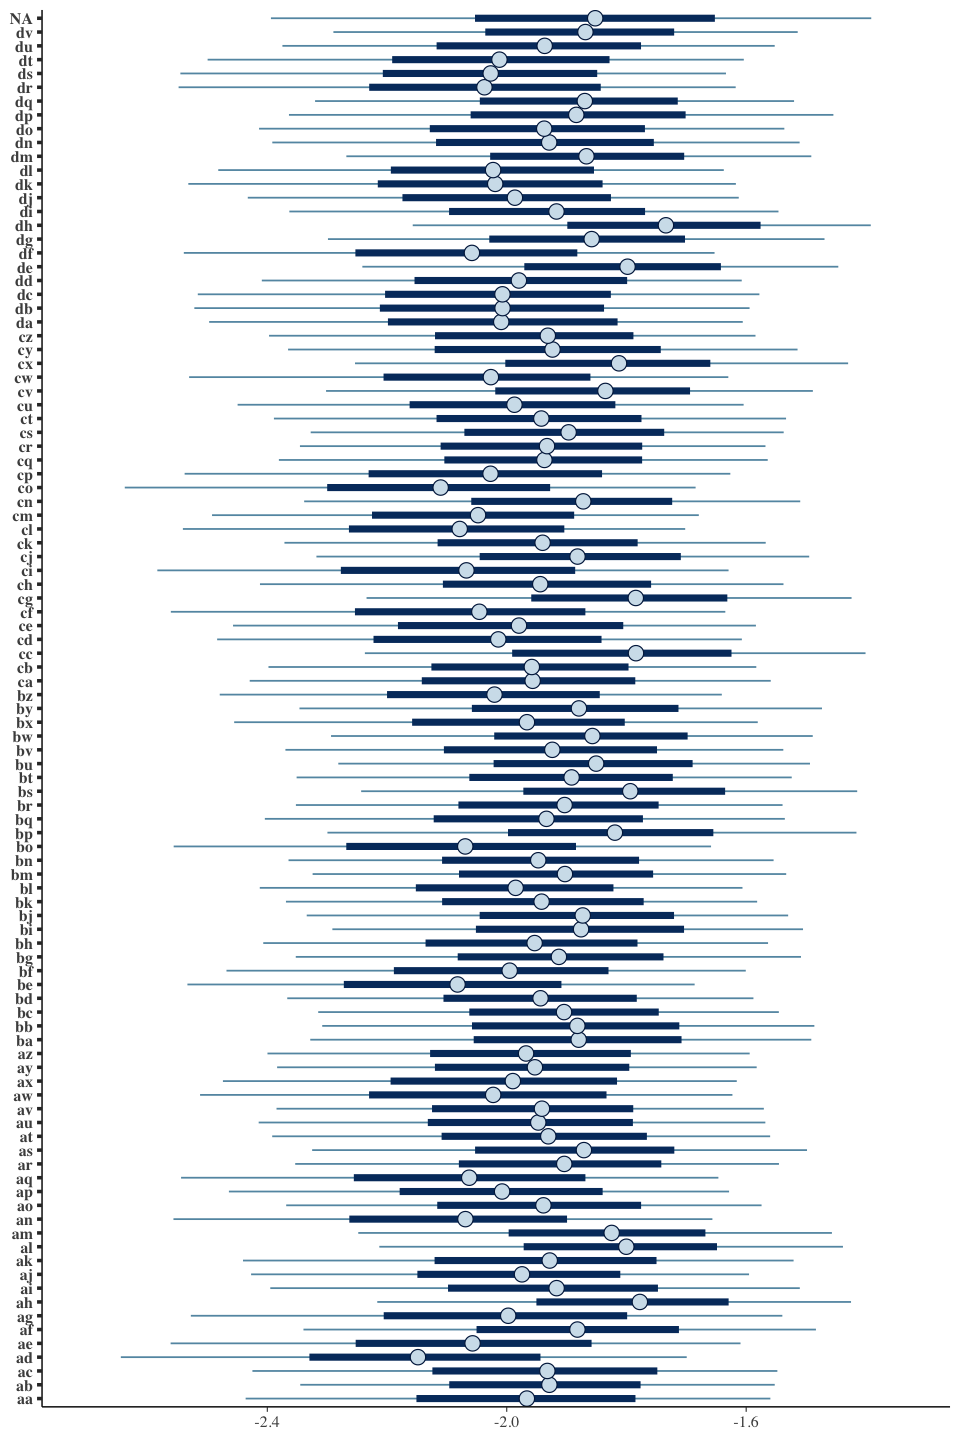

In [135]:
options(repr.plot.width = 8, repr.plot.height = 12)

beta <- as.matrix(fm, regex_pars = "R\\|int")
b <- as.matrix(fm, regex_pars = "R\\|b\\[int")
mat <- sweep(b, MARGIN=1, STATS = beta, FUN = "+")

bayesplot::mcmc_intervals(mat) + scale_y_discrete(labels=fm$groups)

In [136]:
b1_epi = apply(mat, 2, mean)

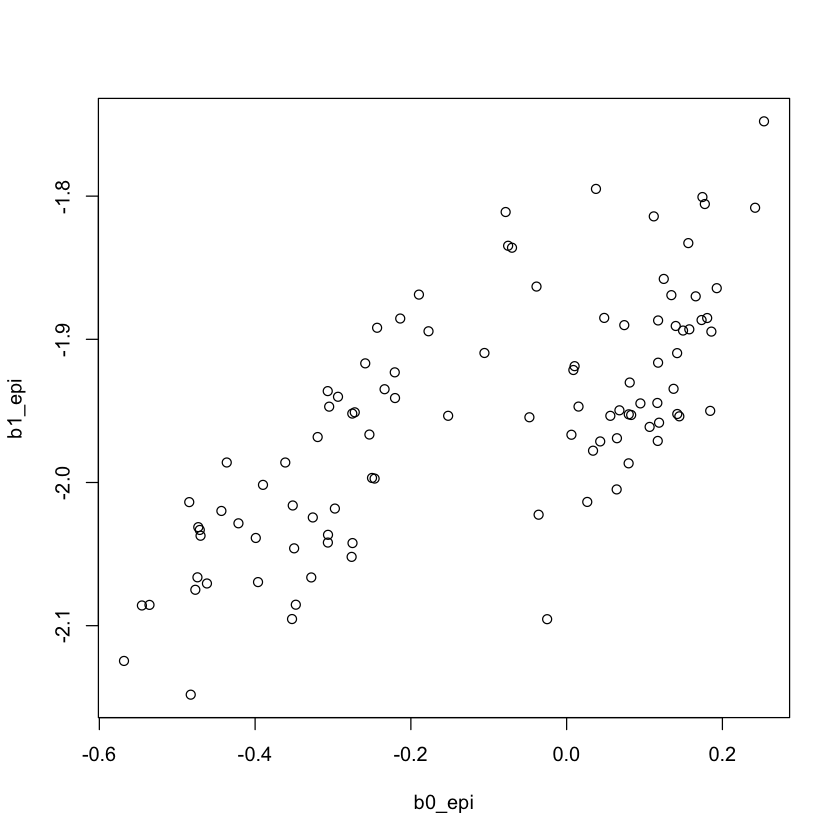

In [137]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(b0_epi, b1_epi)